# Stock Prices Prediction


## Overview

Predicting the stock market is certainly one of the most difficult things to do. There are so many factors involved (physical factors vs. physhological, rational and irrational behaviour, etc). All these aspects combine to make share prices volatile and very difficult to predict with a high degree of accuracy.

Can we use machine learning in this domain? We can use features like the stock price, revenue results, latest announcements about an organization, etc., machine learning techniques have the potential to unearth patterns and insights we didn’t see before, and these can be used to make unerringly accurate predictions.


**Contents**
1. Problem Statement
2. Moving Average
3. Linear Regression
4. k-Nearest Neighbors
5. Auto ARIMA
6. Prophet
7. Long Short Term Memory (LSTM)



## **1. Problem Statement**

In general terms we can divide the stock market analysis into two big areas:
- Fundamental Analysis
- Technical Analysis.

**Fundamental Analysis**: involves analyzing the company’s future profitability on the basis of its current business environment and financial performance.
**Technical Analysis**: on the other hand, includes reading the charts and using statistical figures to identify the trends in the stock market.

As you might have guessed, our focus will be on the technical analysis part. We’ll be using a dataset (you can find historical data for various stocks here).


### Load Basic Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,skmultilearn -g

import os
import sys
import re
from tqdm import tqdm
import yaml
import watermark
from math import floor
from random import random
from pprint import pprint as pp
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import pandas_profiling
from pandas.plotting import register_matplotlib_converters    # for pandas_profiling

from sklearn.preprocessing import MinMaxScaler                # data normalization

register_matplotlib_converters()                              # for pandas_profiling
sys.path.append(os.pardir)
# Set figure size
rcParams['figure.figsize'] = 20,14

from src.ts_func import add_datepart, test_stationarity


CPython 3.7.3
IPython 7.5.0

numpy 1.16.4
pandas 0.24.2
skmultilearn unknown

compiler   : GCC 7.3.0
system     : Linux
release    : 5.0.0-29-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 966669261cbed24d4e42c20eb6bb7993c9fb06ed


### Constants

In [2]:
INPUT_DATA_TATA = "../data/raw/nse_TataGlobal.csv"
INPUT_DATA_MMM = "../data/raw/MMM.csv"

### Load and summarize data

As we want it to be a time series we specify the format of the date and load it as index:

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv(
    INPUT_DATA_TATA, 
    parse_dates=['Date'],    # specifies the column which contains the date-time information
    date_parser=dateparse,   # Specifies a function which converts an input string into datetime variable.
    index_col='Date')

df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1235 entries, 2018-10-08 to 2013-10-08
Data columns (total 7 columns):
Open                    1235 non-null float64
High                    1235 non-null float64
Low                     1235 non-null float64
Last                    1235 non-null float64
Close                   1235 non-null float64
Total Trade Quantity    1235 non-null float64
Turnover (Lacs)         1235 non-null float64
dtypes: float64(7)
memory usage: 77.2 KB


,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-10-08,208.0,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,217.0,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,223.5,227.80,216.15,217.25,218.20,1728786.0,3815.79


In [4]:
df.tail(3)

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2013-10-10,156.0,160.8,155.85,160.3,160.15,3124853.0,4978.80
2013-10-09,155.7,158.2,154.15,155.3,155.55,2049580.0,3204.49
2013-10-08,157.0,157.8,155.20,155.8,155.80,1720413.0,2688.94


In [5]:
# Sort the data by dates
df = df.sort_index(axis=0) 

In [6]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03,1235.000000
mean,168.954858,171.429069,166.402308,168.736356,168.731053,2.604151e+06,4843.166502
std,51.499145,52.436761,50.542919,51.587384,51.544928,2.277028e+06,5348.919832
min,103.000000,104.600000,100.000000,102.600000,102.650000,1.001800e+05,128.040000
25%,137.550000,138.925000,135.250000,137.175000,137.225000,1.284482e+06,1801.035000
50%,151.500000,153.250000,149.500000,151.200000,151.100000,1.964885e+06,3068.510000
75%,169.000000,172.325000,166.700000,169.100000,169.500000,3.095788e+06,5852.600000
max,327.700000,328.750000,321.650000,325.950000,325.750000,2.919102e+07,55755.080000


There are multiple variables in the dataset:
- date
- open, high, low, last, close
- total_trade_quantity
- turnover

The columns *Open* and *Close* represent the starting and final price at which the stock is traded on a particular day. <br>
*High, Low and Last* represent the maximum, minimum, and last price of the share for the day. <br>
*Total Trade Quantity* is the number of shares bought or sold in the day and *Turnover* (Lacs) is the turnover of the particular company on a given date.

Another important thing to notice about the data is the missing dates. The market is closed on weekends and public holidays.

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data:

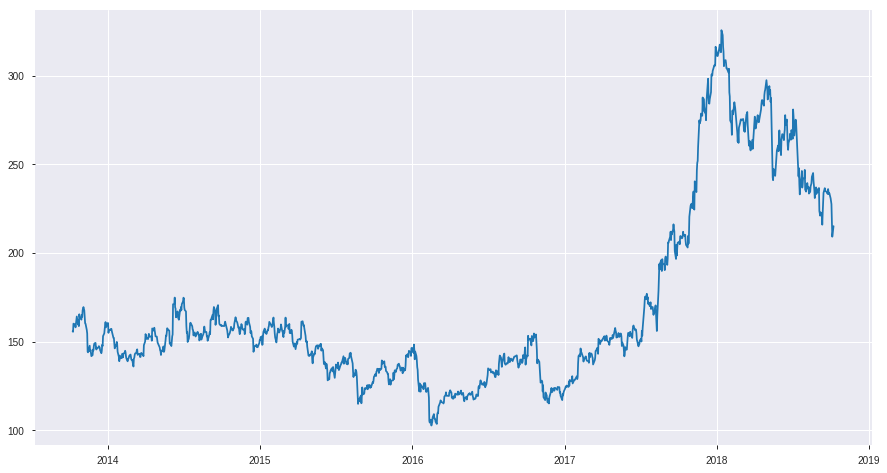

In [7]:
plt.figure(figsize=(15, 8))
plt.plot(df['Close'], label='Close Price history');

In [8]:
# Verify frequency at the index
df.index[:3]

DatetimeIndex(['2013-10-08', '2013-10-09', '2013-10-10'], dtype='datetime64[ns]', name='Date', freq=None)

In [9]:
# Set the frequency to daily
# df = df.to_period('D')
# df.index[:4]

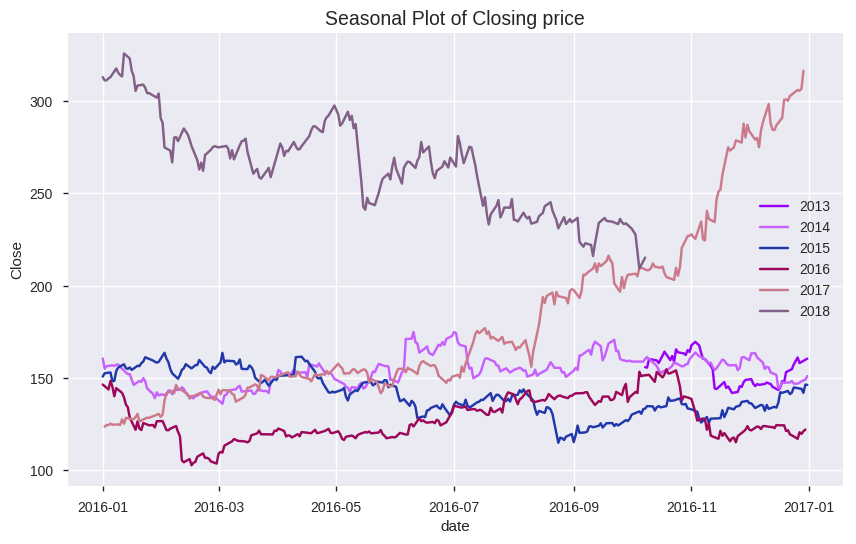

In [10]:
# If we want to see all years overlaying to check possible seasonal behaviour....
df_plot = df.copy()
df_plot["date"] = pd.to_datetime(df_plot.index)
df_plot["month"] = df_plot.date.apply(lambda x: x.month)
df_plot["year"] = df_plot.date.apply(lambda x: x.year)
df_plot["date"] = df_plot.date.apply(lambda x: x.replace(year=2016))
years = df_plot['year'].unique()

# Define Colors
np.random.seed(100)
colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi= 100)
for i, y in enumerate(years):
    sns.lineplot(x="date", y="Close", data=df_plot.loc[df_plot.year==y, :], 
                 ax=ax, color=colors[i], label=str(y))
    
ax.set_title("Seasonal Plot of Closing price",  fontsize=14);

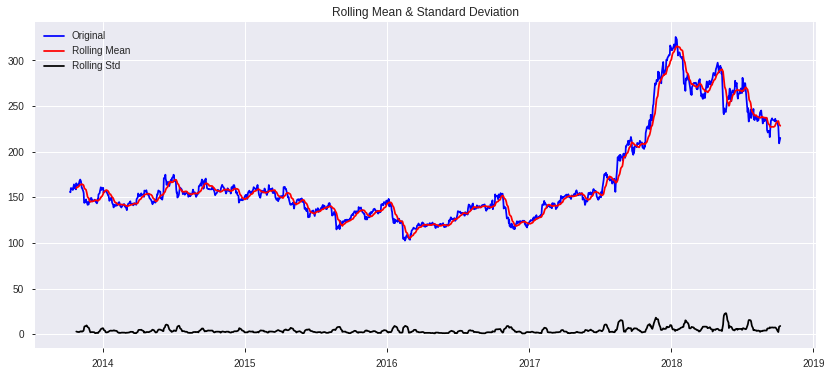

    Augmented Dickey-Fuller Test on "" 
 -----------------------------------------------
Test Statistic                   -0.954896
p-value                           0.769358
#Lags Used                       16.000000
Number of Observations Used    1218.000000
Critical Value (1%)              -3.435730
Critical Value (5%)              -2.863916
Critical Value (10%)             -2.568035
dtype: float64
Significance Level: 0.05
 => P-Value = 0.7694. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [11]:
# If we test for stationarity.... the series is clearly not stationary
test_stationarity(df.Close);

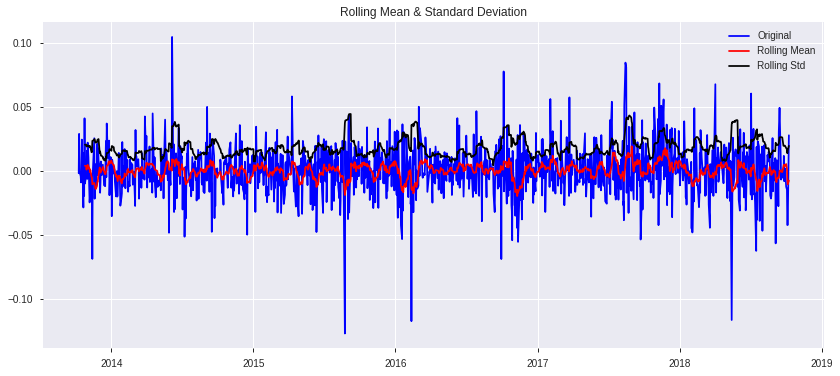

    Augmented Dickey-Fuller Test on "" 
 -----------------------------------------------
Test Statistic                -1.766813e+01
p-value                        3.655511e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.230000e+03
Critical Value (1%)           -3.435678e+00
Critical Value (5%)           -2.863893e+00
Critical Value (10%)          -2.568023e+00
dtype: float64
Significance Level: 0.05
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [12]:
# Eliminate trend and seasonality by applying log and differenciation
df_close_log = np.log(df.Close)
df_log_diff = df_close_log - df_close_log.shift()
df_log_diff = df_log_diff[1:]
test_stationarity(df_log_diff);

Now we have transformed the series into a stationary serie.

Divide into train and test sets.

In [13]:
n_tr = int(0.8 * df.shape[0])
df_tr = df[:n_tr].copy()
df_te = df[n_tr:].copy()

data = df_log_diff.copy()
n_div = int(0.8 * df_log_diff.shape[0])
df_train = df_log_diff[:n_div].copy()
df_test = df_log_diff[n_div:].copy()

print(f'Total: {data.shape} \nTrain: {df_train.shape} \nTest: {df_test.shape}')

Total: (1234,) 
Train: (987,) 
Test: (247,)


## **2. Moving Average**

*Averaging* is used in many applications to sum and understand the values and behaviours of many things.

In the *Moving Average*, the predicted closing price for each day will be the average of a set of previously observed values within a specific time window, for example the latest 20 values.


In [14]:
# Predictions using the moving average
window = df_test.shape[0]
preds = []
for i in range(0, window):
    a = df_train[len(df_train) - window + i:].sum() + sum(preds)
    b = a/window
    preds.append(b)
    
# Calculate RMSE
calculate_rmse = lambda x, y: np.sqrt(np.mean(np.power((np.array(x) - y), 2)))
rmse = calculate_rmse(df_test, preds)
print(f'RMSE: {round(rmse, 3)}')

RMSE: 0.022


In [15]:
# Plot to have a visual representation...
df_results = pd.DataFrame({"Close": df_test})
df_results['Predictions'] = preds

# Transform back the results
def revert_transformation(train, test, ini=df.Close[0]):
    rev_train = ini + np.exp(train.cumsum())
    rev_test = np.exp(test.cumsum())
    ref = np.exp(df_results.cumsum()).iloc[0, :]
    rev_test = rev_test + rev_train[-1] - ref
    
    plt.figure(figsize=(15, 8))
    plt.plot(rev_train);
    plt.plot(rev_test);

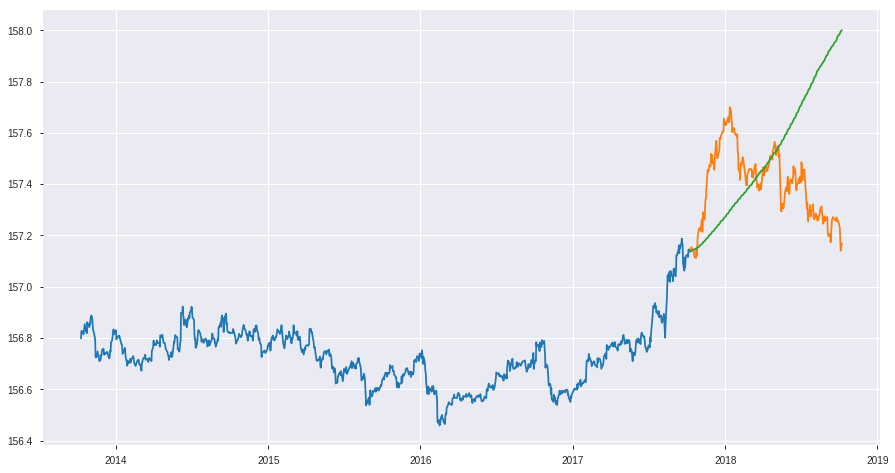

In [16]:
revert_transformation(df_train, df_results)

The graph is very clear, the RMSE value is small but the results are not promising. The predicted values are the average of the observed values and thus in the same range and they try to replicate the trend.

If we apply the same model without the stationary serie, we obtain again a replica of the trend with an initial increase and posterior decrease plus a big offset due again to averaging....

RMSE: 104.196


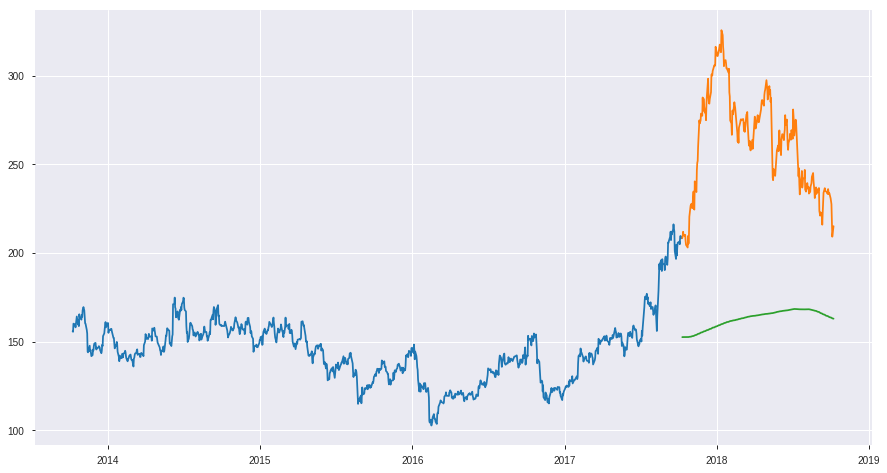

In [17]:
# Predictions using the moving average
window = df_te.shape[0]
pre = []
for i in range(0, window):
    a = df_tr['Close'][len(df_tr) - window + i:].sum() + sum(pre)
    b = a/window
    pre.append(b)
    
# Calculate RMSE
calculate_rmse = lambda x, y: np.sqrt(np.mean(np.power((np.array(x) - y), 2)))
rmse = calculate_rmse(df_te['Close'], pre)
print(f"RMSE: {round(rmse, 3)}")

# Plot to have a visual representation...
df_te['Predictions'] = 0
df_te['Predictions'] = pre

plt.figure(figsize=(15, 8))
plt.plot(df_tr['Close']);
plt.plot(df_te[['Close', 'Predictions']]);

## **3. Linear Regression**

The most basic ML algorithm that can be implemented on this data is linear regression. The linear regression model returns an equation that determines the relationship between the independent variables and the dependent variable.


In [18]:
data = df.copy()
add_datepart(data, 'index')
data.drop('dateElapsed', axis=1, inplace=True)

This creates features such as:

‘Year’, ‘Month’, ‘Week’, ‘Day’, ‘Dayofweek’, ‘Dayofyear’, ‘Is_month_end’, ‘Is_month_start’, ‘Is_quarter_end’, ‘Is_quarter_start’,  ‘Is_year_end’, and  ‘Is_year_start’.

Apart from this we can add our own set of features. For instance if we have the hypothesis that the first and last days of the week could potentially affect the closing price of the stock far more than the other days we can create a feature for it:

In [19]:
data['mon_fri'] = data['dateDayofweek'].apply(lambda x: x in [0, 4])
data['mon_fri'] = data['mon_fri'].astype(int)

In [21]:
# Split data as before
df_tr = data[:n_tr].copy()
df_te = data[n_tr:].copy()
# Eliminate any reference to the value...
value_columns_to_drop = ["Close", "Open", "High", "Low", "Last"]
x_tr = df_tr.drop(value_columns_to_drop, axis=1)
y_tr = df_tr['Close']
x_te = df_te.drop(value_columns_to_drop, axis=1)
y_te = df_te['Close']

In [22]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(x_tr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Evaluate Model:

In [23]:
# make predictions and find the rmse
preds = linear_model.predict(x_te)
rmse = calculate_rmse(y_te, preds)
print(f'RMSE: {round(rmse, 3)}')

RMSE: 72.315


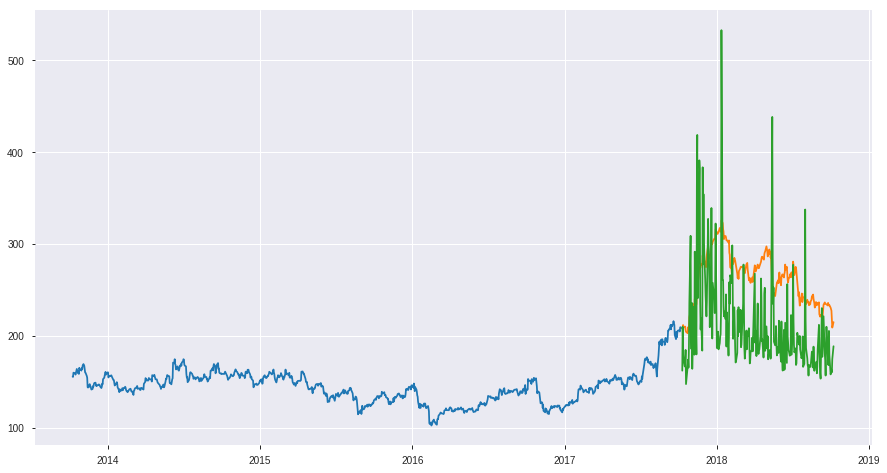

In [24]:
# Plot to have a visual representation...
df_te['Predictions'] = 0
df_te['Predictions'] = preds

df_te.index = data[n_tr:].index
df_tr.index = data[:n_tr].index
plt.figure(figsize=(15, 8))
plt.plot(df_tr['Close']);
plt.plot(df_te[['Close', 'Predictions']]);

## **4. k-Nearest Neighbors**

Based on the independent variables kNN finds the similarity between new data points and old data points.


In [25]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale data
x_tr_scaled = scaler.fit_transform(x_tr)
x_tr = pd.DataFrame(x_tr_scaled)
x_te_scaled = scaler.fit_transform(x_te)
x_te = pd.DataFrame(x_te_scaled)

# gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

# fit model and make predictions
model.fit(x_tr,y_tr)
preds = model.predict(x_te)

# Evaluation
rmse = calculate_rmse(y_te, preds)
print(f'RMSE: {round(rmse, 3)}')

RMSE: 113.934


/home/greg/anaconda3/envs/dev37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


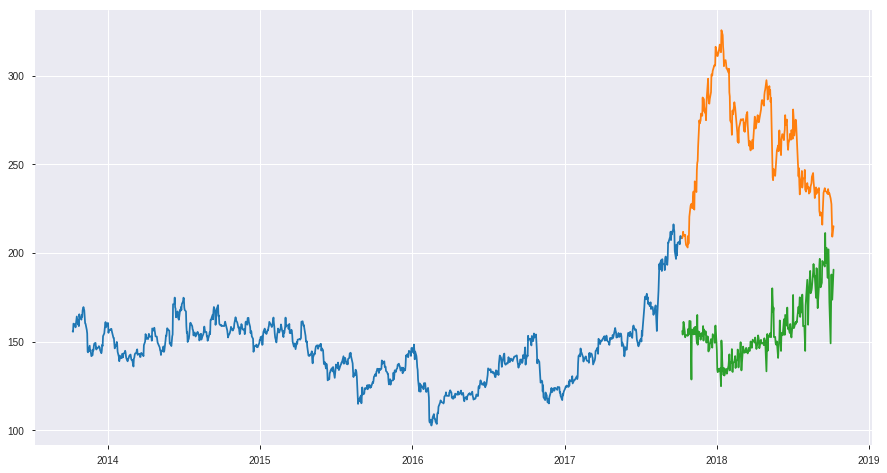

In [27]:
df_te['Predictions'] = 0
df_te['Predictions'] = preds

plt.figure(figsize=(15, 8))
plt.plot(df_tr['Close']);
plt.plot(df_te[['Close', 'Predictions']]);

Like linear regression kNN also identified a drop in January 2018 since that has been the pattern for the past years. We can safely say that regression algorithms have not performed well on this dataset.

Let’s go ahead and look at some time series forecasting techniques to find out how they perform when faced with this stock prices prediction challenge.

## **5. Auto ARIMA**

ARIMA is a very popular statistical method for TS forecasting. ARIMA models take into account the past values to predict the future values. There are three important parameters in ARIMA:

- p (past values used for forecasting the next value)
- q (past forecast errors used to predict the future values)
- d (order of differencing)

Parameter tuning for ARIMA consumes a lot of time. So we will use auto ARIMA which automatically selects the best combination of (p,q,d) that provides the least error.

In [28]:
# !conda install -c saravji pmdarima 

from pmdarima.arima import auto_arima

data = df.copy()
df_train = data[:n_tr].copy()
df_test = data[n_tr:].copy()

y_tr = df_train['Close']
y_te = df_test['Close']

model = auto_arima(y_tr, start_p=1, start_q=1,max_p=3, max_q=3, 
                   m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,
                   error_action='ignore',suppress_warnings=True)
model.fit(y_tr)

forecast = model.predict(n_periods=window)
forecast = pd.DataFrame(forecast, index=df_test.index, columns=['Prediction'])


/home/greg/anaconda3/envs/dev37/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/greg/anaconda3/envs/dev37/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4824.876, BIC=4849.288, Fit time=3.109 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5483.957, BIC=5493.722, Fit time=0.053 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5174.971, BIC=5194.500, Fit time=0.690 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4822.842, BIC=4842.372, Fit time=2.222 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4820.861, BIC=4845.274, Fit time=2.009 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5174.971, BIC=5194.500, Fit time=0.676 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4822.627, BIC=4851.922, Fit time=9.377 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5485.864, BIC=5500.511, Fit time=0.169 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=4823.233, BIC=4857.410, Fit time=8.780 seconds
Fit ARIMA: order=(1, 1, 1) s

In [29]:
# Evaluation:
rmse = calculate_rmse(y_te, forecast['Prediction'])
print(f'RMSE: {round(rmse, 3)}')

RMSE: 45.37


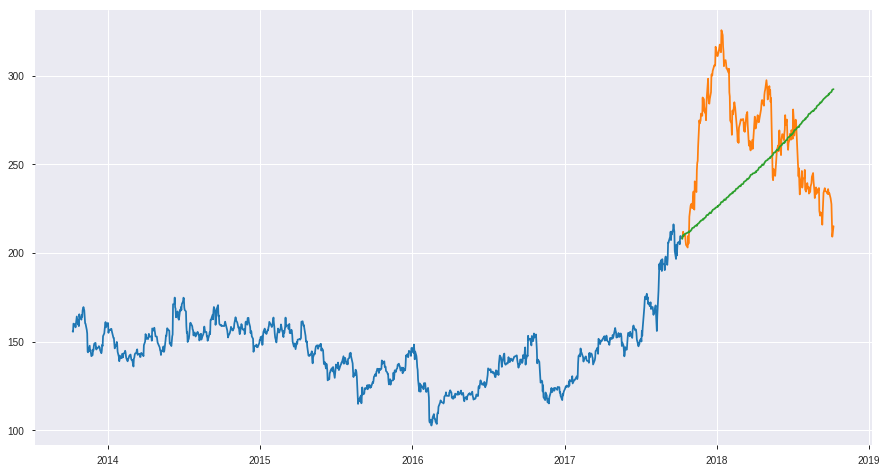

In [30]:
plt.figure(figsize=(15, 8))
plt.plot(df_train['Close']);
plt.plot(df_test['Close']);
plt.plot(forecast['Prediction']);

## **6. Prophet**

There are a number of TS techniques that can be implemented on the stock prediction but most of these techniques require a lot of data preprocessing before fitting the model. Prophet (by Facebook) is a TS forecasting library that requires no data preprocessing and is extremely simple to implement. The input for Prophet is a dataframe with two columns: date and target (ds and y).

Prophet tries to capture the seasonality in the past data and works well when the dataset is large. It is based on **decomposable (trend+seasonality+holidays) models**. It provides the ability to make TS predictions with good accuracy using simple intuitive parameters and has support for including impact of custom seasonality and holidays.


#### 6.1 Prophet Intro
When a forecasting model doesn’t run as planned, we want to be able to tune the parameters of the method with regards to the specific problem at hand. Tuning these methods requires a thorough understanding of how the underlying time series models work. The first input parameters to automated ARIMA, for instance, are the maximum orders of the differencing, the auto-regressive components, and the moving average components. A typical analyst will not know how to adjust these orders to avoid the behaviour and this is the type of expertise that is hard to acquire and scale.

Prophet provides intuitive parameters which are **easy to tune**. Even someone who lacks expertise in forecasting models can use this to make meaningful predictions for a variety of problems in a business scenario.


#### 6.2 The Prophet Forecasting Model
We use a decomposable TS model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

\begin{equation*}
y​(t) ​​=​​g​(t)​​+​​ s​(t) ​​+​​ h​(t) ​​+​​ \epsilon_t​
\end{equation*}

* g(t): piecewise linear or logistic growth curve for modelling non-periodic changes in time series
* s(t): periodic changes (e.g. weekly/yearly seasonality)
* h(t): effects of holidays (user provided) with irregular schedules
* εt: error term accounts for any unusual changes not accommodated by the model

Using time as a regressor, Prophet is tries to fit several linear and non linear functions of time as components. Modeling seasonality as an additive component is the same approach taken by exponential smoothing in Holt-Winters technique . The forecasting problem is framed as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a TS.


#### 6.3 Trend
Trend is modelled by fitting a piece wise linear curve over the trend or the non-periodic part of the time series. The linear fitting exercise ensures that it is least affected by spikes/missing data.

##### 6.3.1 *Saturating growth*
Do we expect the target to keep growing/falling for the entire forecast interval?

Let’s say we are forecasting number of downloads of an app in a region for the next 12 months. The maximum downloads is always capped by the total number of smartphone users in the region. The number of smartphone users will also, however, increase with time.

With domain knowledge at his/her disposal, an analyst can then define a varying capacity C(t) for the time series forecasts he/she is trying to make.

##### 6.3.2 *Changepoints*
Another question to answer is whether my TS encounters any underlying changes in the phenomena e.g. a new product launch, unforeseen calamity etc.  At such points, the growth rate is allowed to change. These changepoints are automatically selected. However, a user can also feed the changepoints manually if it is required.

As the number of changepoints allowed is increased the fit becomes more flexible. There are basically 2 problems an analyst might face while working with the trend component:
* Overfitting
* Underfitting

A parameter called changepoint_prior_scale could be used to adjust the trend flexibility and tackle the above 2 problems. Higher value will fit a more flexible curve to the TS.

#### 6.4 Seasonality
To fit and forecast the effects of seasonality, prophet relies on fourier series to provide a flexible model. Seasonal effects s(t) are approximated by the following function:

\begin{equation*}
s​(t) ​​=​​\sum_{n-1}^N \left( ​\alpha_n ​ cos \left( {\frac{2 \pi n t}{P}} \right)​​+​​ b_n​sin \left( {\frac{2 \pi n t}{P}} \right) \right)
\end{equation*}

Where **P** is the period (365.25 for yearly data and 7 for weekly data)

Parameters [a1, b1, ….., aN, bN] need to be estimated for a given N to model seasonality.

The fourier order N that defines whether high frequency changes are allowed to be modelled is an important parameter to set here. For a time series, if the user believes the high frequency components are just noise and should not be considered for modelling, he/she could set the values of N from to a lower value. If not, N can be tuned to a higher value and set using the forecast accuracy.

#### 6.5 Holidays & Events
Holidays and events incur predictable shocks to a TS. For instance, Diwali in India occurs on a different day each year and a large portion of the population buy a lot of new items during this period.

Prophet allows the analyst to provide a custom list of  past and future events. A window around such days are considered separately and additional parameters are fitted to model the effect of holidays and events.


In [36]:
from fbprophet import Prophet

# We only need in the dataset the value to predict and the date
data = pd.DataFrame(data={'ds': df.index, 'y': df['Close'].values}, 
                    index=range(0, len(df)))
# Define train and test sets
df_tr = data[:n_tr]
df_te = data[n_tr:].copy()

# Fit the model
model = Prophet(daily_seasonality=False)
model.fit(df_tr)

# Predict
close_prices = model.make_future_dataframe(periods=len(df_te))
forecast = model.predict(close_prices)

/home/greg/anaconda3/envs/dev37/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [37]:
# RMSE
forecasted_close_price = forecast['yhat'][n_tr:]
rmse = calculate_rmse(df_te['y'], forecasted_close_price)
print(f'RMSE: {round(rmse, 3)}')

RMSE: 56.384


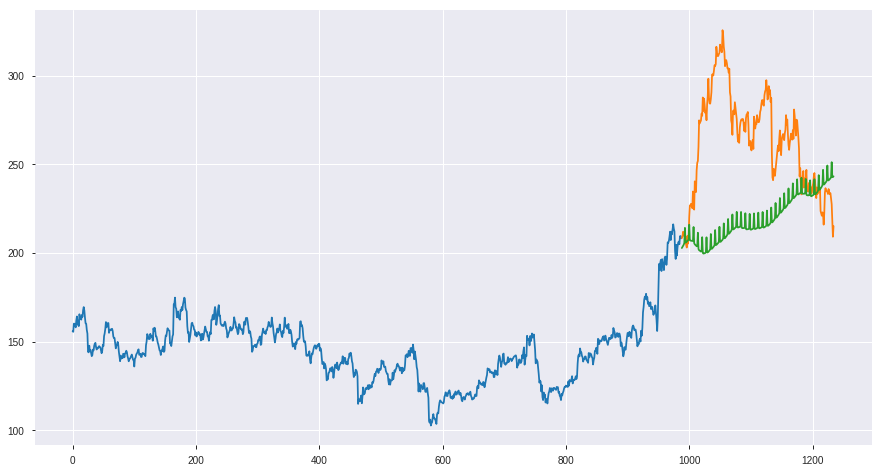

In [38]:
df_te['Predictions'] = forecasted_close_price.values

plt.figure(figsize=(15, 8))
plt.plot(df_tr['y']);
plt.plot(df_te[['y', 'Predictions']]);

Prophet (like most TS forecasting techniques) tries to capture the trend and seasonality from past data. This model usually performs well on TS datasets, but fails to live up to it’s reputation in this case.

As it turns out, stock prices do not have a particular trend or seasonality. It highly depends on what is currently going on in the market and thus the prices rise and fall. Hence forecasting techniques like ARIMA, SARIMA and Prophet would not show good results for this particular problem.

## **7. Long Short Term Memory (LSTM)**

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

* The input gate: The input gate adds information to the cell state
* The forget gate: It removes the information that is no longer required by the model
* The output gate: Output Gate at LSTM selects the information to be shown as output




In [39]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# We only need in the dataset the value to predict and the date
data = df[['Close']].copy()

# Define train and test sets
dataset = data.values

df_tr = dataset[:n_tr]
df_te = dataset[n_tr:]

# Converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(df_tr)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

Using TensorFlow backend.


In [40]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = data[len(data) - len(df_te) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Epoch 1/1
 - 144s - loss: 0.0011


In [41]:
# RMSE
rmse = np.sqrt(np.mean(np.power((df_te - closing_price),2)))
print(f'RMSE: {round(rmse, 3)}')

RMSE: 21.333


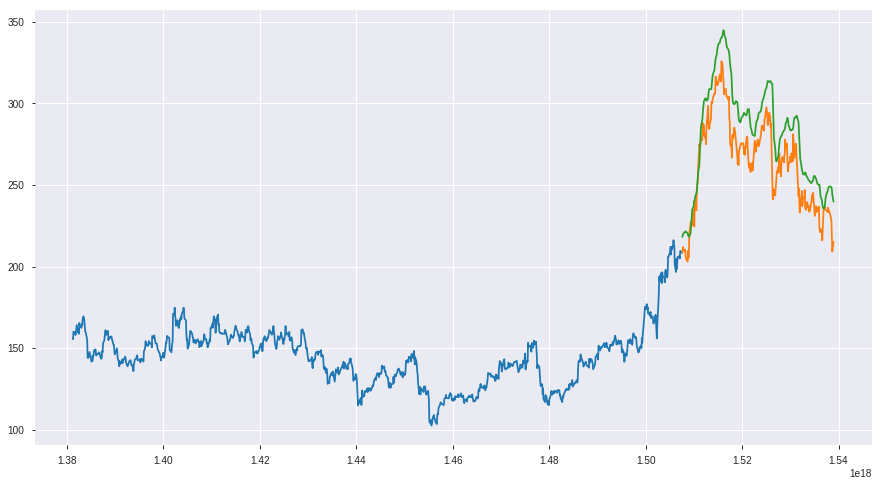

In [42]:
df_train = data[:n_tr].copy()
df_test = data[n_tr:].copy()
df_test.loc[:, 'Predictions'] = closing_price

plt.figure(figsize=(15, 8))
plt.plot(df_train['Close']);
plt.plot(df_test[['Close','Predictions']]);

The LSTM model can be tuned for various parameters such as changing the number of LSTM layers, adding dropout value or increasing the number of epochs. But are the predictions from LSTM enough to identify whether the stock price will increase or decrease? Certainly not!

As I mentioned at the start of the article, stock price is affected by the news about the company and other factors like demonetization or merger/demerger of the companies. There are certain intangible factors as well which can often be impossible to predict beforehand.

In [43]:
df_train.columns

Index(['Close'], dtype='object')